# Mercari Price Suggestion Challenge
* 일본의 대형 온라인 쇼핑몰인 Mercari 사의 제품에 대해 가격을 예측하는 과제.
* 데이터 세트는 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터로 구성.
* https://www.kaggle.com/c/mercari-price-suggestion-challenge/data


# 데이터 로딩 및 전처리

In [1]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/파이썬_머신러닝_완벽가이드/08_Text_Analytics/mercari_price_suggestion_challenge/train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


### 데이터 세트 속성
* train_id : 데이터 id
* name : 제품명
* item_condition_id : 판매자가 제공하는 제품 상태
* category_name : 카테고리 명
* brand_name : 브랜드 이름
* price : 제품 가격. 예측을 위한 타깃 속성
* shipping : 배송비 무료 여부. 1이면 무료(판매자가 지불), 0이면 유료(구매자 지불)
* item_description : 제품에 대한 설명

price가 예측해야할 타깃값이다. 회귀로 피처를 학습한 뒤 price를 예측하는 문제. Mercari Price Suggestion은 item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행한다.

In [2]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


* brand_name 칼럼의 경우 매우 많은 Null을 가지고 있음. 가격에 영향을 미치는 중요 요인으로 판단되지만, 많은 데이터가 Null로 되어있다.
* category_name은 약 6300 건의 null 데이터를 가지고 있다.
* item_description의 null 값은 4건으로 미비하다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


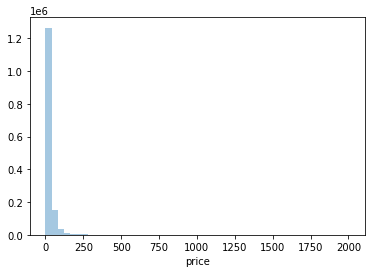

In [3]:
# Target 값인 price 칼럼의 데이터 분포도 확인
# 회귀에서는 Target 값의 정규 분포도는 매우 중요.
# 왜곡되어 있을 경우 로그를 씌워 변환 -> 대부분 정규 분포의 형태를 가지게 됨
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6, 4))
sns.distplot(y_train_df, kde=False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


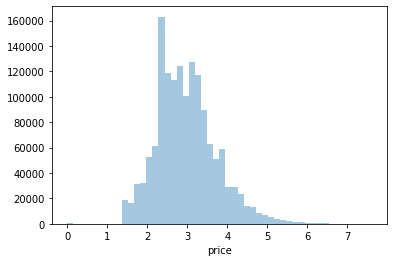

In [4]:
# price 값이 적은 가격쪽에 왜곡되어 있다. 로그 값으로 변환하여 정규화
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

In [5]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [6]:
# shipping과 item_condition_id 값 확인
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


* Shipping 칼럼 : 배송비 유무. 값이 비교적 균일하다.
* Item_condition_id : 판매자가 제공하는 제품 상태. 1, 2, 3 값이 주를 이루고 있다.
* item_description : Null은 별로 없지만, 별도 값이 없는 경우 'No description yet' 값으로 되어있다.

In [7]:
boolean_cond = mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

* 'No description yet'의 경우도 Null과 마찬가리로 의미 있는 속성값으로 사용될 수 없으므로 적절한 값으로 변경해야 한다.

category_name은 '/'로 분리된 카테고리를 하나의 문자열로 나타내고 있다. 'Men/Tops/T-shirts'는 대분류 'Men', 중분류 'Tops', 소분류 'T-shirts'로 나눌 수 있다. category_name은 텍스트이므로 피처 추출 시 tokenizer를 '/'로 하여 단어를 분리해 벡터화할 수도 있지만, category_name의 '/'를 기준으로 단얼르 토큰화하여 각각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습.

* split_cat() 함수
    * category_name이 Null이 아닌 경우 split('/')를 이용해 대, 중, 소분류를 분리.
    * category_name이 Null일 경우 split() 함수가 Error를 발생하므로 이 Error를 except catch하여 대, 중, 소분류 모두 'Other Null' 값을 부여.

In [8]:
# apply lambda에서 호출되는 대, 중, 소분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercary_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중, 소 분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


brand_name, category_name, item_description 칼럼의 Null 값은 일괄적으로 'Other Null'로 동일하게 변경.

In [9]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null 값 건수 확인
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

### 피처 인코딩과 피처 벡터화
* 선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로 인코딩할 피처는 모두 원-핫 인코딩을 적용.
* 피처 벡터화의 경우는 비교적 짧은 텍스트의 경우 Count 기반의 벡터화, 긴 텍스트의 경우 TD-IDF 기반의 벡터화 적용.

In [10]:
# brand_name 칼럼 - 상품의 브랜드명
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


brand_name의 경우 대부분 명료한 문자열로 되어있다. 별도의 피처 벡터화 형태로 만들 필요없이 인코딩 변환을 적용.

In [11]:
# name 칼럼 - 상품명
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

name 의 종류 갯수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


상품명은 name 속성의 경우 종류가 매우 많다. name 속성은 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 되어있으므로 Count 기반으로 피처 벡터화 변환 적용.

* category_name 칼럼을 변환시킨 cat_dae, cat_jung, cat_so 칼럼 : 원-핫 인코딩 적용
* shipping 칼럼 : 0, 1 두 가지 유형의 값을 가지고 있음, 원-핫 인코딩 적용
* item_condition_id 칼럼 : 상품 상태로 1, 2, 3, 4, 5의 다섯 가지 유형의 값을 가지고 있음, 원-핫 인코딩 적용
* item_description 칼럼 : 상품에 대한 간단 설명으로, 가장 긴 텍스트를 가지고 있음. TF-IDF로 피처 벡터화 후 인코딩 수행

In [12]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [13]:
# name 속성에 대한 피처 벡터화 변환
cnt_vect = CountVectorizer()
X_name = cnt_vect.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태이다. 희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트를 구성해야 하고, cat_dae, cat_jung, cat_so, brand_name, shipping, item_condition_id도 모두 X_name, X_descp와 결합해 ML 모델을 실행하는 기반 데이터 세트로 재구성되어야 한다.

이를 위해 이 인코딩 대상 칼럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤, 함께 결합하도록 한다.

#### 사이킷런의 원-핫 인코딩 클래스
* OneHotEncoder
* LabelBinarizer : 희소 행렬 형태의 원-핫 인코딩 변환을 지원. 생성 시 sparse_out=True로 파라미터를 설정해주기만 하면 된다.

개별 칼럼으로 만들어진 희소 행렬은 사이파이 패키지인 sparse 모듈의 hstack() 함수를 이용해 결합한다. hstack() 함수는 희소 행렬을 손쉽게 칼럼 레벨로 결합할 수 있게 해준다.

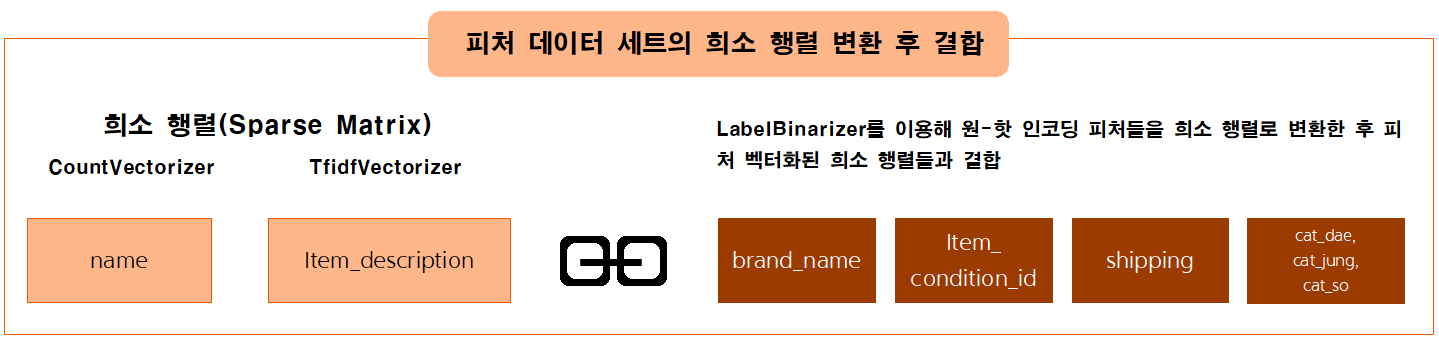

In [14]:
# 인코딩 대상 칼럼 모두 LabelBinarizer로 원-핫 인코딩 변환
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [15]:
# 확인
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입이다. 그리고 brand_name 칼럼 경우 값의 유형이 4810개이므로 이를 원-핫 인코딩으로 변환환 X_brand_shape의 경우 4810개의 인코딩 칼럼을 가지게 되었다. X_cat_so의 경우도 마찬가지로 871개의 인코딩 칼럼을 가진다. 인코딩 칼럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 크게 문제될 것은 없다. 

In [16]:
# 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()을 이용해 모두 결합
# 결합된 데이터는 Mercari Price Suggestion을 위한 기반 데이터 세트로 사용됨.
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합.
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


153

hstack()으로 결합한 데이터 세트는 csr_matrix 타입이며, 총 161569개의 피처를 가지게 되었다. 이렇게 만들어진 데이터 세트에 회귀를 적용하여 price 값을 예측할 모델 구축.

### 릿지 회귀 모델 구축 및 평가

* 평가 지표 - RMSLE(Root Mean Square Logarithmic Error)
    * 낮은 가격보다 높은 각겨에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해 RMSLE를 도입

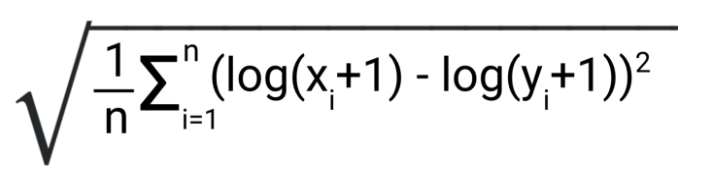

In [17]:
def rmsle(y, y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

#### 학습용 데이터를 생성하고, 모델을 학습/예측하는 로직 함수 구현

In [18]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X = hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test 

#### Ridge를 이용하여 Mercari Price 회귀 예측
* item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 확인.

In [19]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5023727038010544
Item Description을 포함한 rmsle 값: 0.4712195143433641


Item Description을 포함했을 때 rmsle 값이 많이 감소했다. 즉, Item Description 영향이 중요하다는 것을 알 수 있다.

### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가
* n_estimators : 1000 이상 증가시키면 예측 성능은 좋아지나, 시간이 많이 걸린다. 여기서는 200으로 작게 설정한다.

In [20]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

LightGBM rmsle 값: 0.45719580244261243


Ridge보다 예측 성능이 조금 더 나아졌다.

* LightGBM의 예측값과 Ridge의 예측값을 서로 앙상블하여 최종 예측 결과값을 도출.
* LightGBM 예측값에 X를 곱하고, Ridge 예측값에 Y를 곱한 값을 서로 합해 최종 예측 결과값으로 한다.(X와 Y의 배합 비율은 임의로 산정)

In [21]:
preds = lgbm_preds * 0.4 + linear_preds * 0.6
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.45188477431350804


In [22]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4507259214329315


In [23]:
preds = lgbm_preds * 0.5 + linear_preds * 0.5
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4498568634788895


In [24]:
preds = lgbm_preds * 0.55 + linear_preds * 0.45
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4492792821384937


In [25]:
preds = lgbm_preds * 0.6 + linear_preds * 0.4
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.44899430227008386


# 정리

### 텍스트 분석 프로세스
1. 텍스트 사전 정제 작업 등의 텍스트 정규화 작업 수행
2. 단어들을 피처 벡터화로 변환
3. 생성된 피처 벡터 데이터 세트에 머신러닝 모델을 학습하고 예측, 평가 수행

### 텍스트 정규화 작업
* 텍스트 클렌징 및 대소문자 변경, 단어 토큰화, 의미 없는 단어 필터링, 어근 추출 등 피처 벡터화를 진행하기 이전에 수행하는 다양한 사전 작업을 의미
* 피처 벡터화 : BOW의 대표 방식인 Count 기반과 TF-IDF 기반 피처 벡터화
* 일반적으로 긴 문장에서는 TF-IDF 기반의 피처 벡터가 더 정확한 결과를 도출
* 피처 벡터 데이터 세트는 희소 행렬이며, 머신러닝 모델은 이러한 희소 행렬 기반에서 최적화 되어야 한다.

### 텍스트 분류
* 피처 벡터화한 후 로지스틱 회귀를 적용하여 문서를 지도 학습으로 예측 분류

### 감성 분류
* 지도 학습 기반으로 긍정/부정 이진 분류를 적용한 방식
* SentiWordNet, VADER과 같은 감성 사전 Lexicon을 이용한 방식

### 토픽 모델링
* LDA(Latent Dirichlet Allocation)을 이용해 공통 토픽 추출

### 텍스트 군집화
* K-평균 군집화 기법을 이용해 비슷한 문서들끼리 군집화

### 텍스트 유사도 측정
* 코사인 유사도를 이용하여 문서들끼리 얼마나 비슷한지를 측정

### 한글 형태소 분석기
* KoNLPy 패키지를 이용하여 한글 형태소를 분석하여 긍정/부정 이진 분류

### Mercari Price Challenge
* 정형 피처들과 텍스트와 같은 비정형 피처를 결합하여 효과적인 회귀 예측 모델 구현

